※ Global variables

In [230]:
import torch

gnDataset = 3
gBase_path = 'CAS771/Task1_data'
gnClasses = 5

gDropout_rate = [0.5, 0.5, 0.5]
gBatch_momentum = [0.2, 0.2, 0.2]
gLearning_rate = [0.00001, 0.00001, 0.00001]
gWeight_decay = [1e-3, 1e-3, 1e-3]
gOpt_Momentum = [0.9, 0.9, 0.9]

gData_batch_size = 64
gEarly_stop_patience = 15
gnEpochs = 100
gbData_augmentation = True

gModel_names = ["cnn", "cnn", "resnet"] # "resnet", "cnn"
gOptimizer_names = ["Adam", "Adam", "Adam"] # "Adam", "SGD"
gCriterion_names = ["CrossEntropyLoss", "CrossEntropyLoss", "CrossEntropyLoss"]


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

※ Widget functions

In [231]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label

def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    labels = raw_data['labels']
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def load_class_names(filepath):
    with open(filepath, 'r') as file:
        classes = [line.strip() for line in file]
    return classes

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count


class CAS771Plot():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
        
        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples
        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()    


class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= gEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def load_data(train_data_path, test_data_path, m=0, save_class_mapping=True):
    train_data, train_labels = _load_data(train_data_path)
    unique_labels = sorted(set(train_labels))
    class_mapping = {label: i for i, label in enumerate(unique_labels)}
    print(f"Class mapping: {class_mapping}")
    
    if train_data_path == None:
        train_dataloader = None
    else:
        train_remapped_labels = remap_labels(train_labels, class_mapping)
        transform = get_data_augmentation("train")
        train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=transform)
        train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)

        if save_class_mapping:
            # Save the mapping to a file
            class_mapping_path = f'{gBase_path}/Model{m+1}/class_mapping_model_{m+1}.pkl'
            with open(class_mapping_path, "wb") as f:
                pickle.dump(class_mapping, f)

    if test_data_path == None:
        test_dataloader = None
    else:
        test_data, test_labels = _load_data(test_data_path)
        remapped_test_labels = remap_labels(test_labels, class_mapping)
        transform = get_data_augmentation("test")
        test_dataset = CAS771Dataset(test_data, remapped_test_labels, transform=transform)
        test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)

    return train_dataloader, test_dataloader

※ Datasets

In [232]:
train_data_paths = [f'{gBase_path}/Model{i}/model{i}_train.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/Model{i}/model{i}_test.pth' for i in range(1, gnDataset+1)]
print(train_data_paths)
print(test_data_paths)

classes_path = gBase_path + '/cifar100_classes.txt'
classes = load_class_names(classes_path)
print(classes)

['CAS771/Task1_data/Model1/model1_train.pth', 'CAS771/Task1_data/Model2/model2_train.pth', 'CAS771/Task1_data/Model3/model3_train.pth']
['CAS771/Task1_data/Model1/model1_test.pth', 'CAS771/Task1_data/Model2/model2_test.pth', 'CAS771/Task1_data/Model3/model3_test.pth']
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea'

※ Models

1. ResNet18

In [233]:
# Define Basic Block (Residual Block)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0, batch_momentum=0.1):
        super(BasicBlock, self).__init__()
        # 1st Convolution Layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # 2nd Convolution Layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=batch_momentum)
        
        # Skip connection (identity)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels, momentum=batch_momentum)
            )

        # Dropout Layer (After Batch Normalization)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Residual connection + ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # skip connection
        out = F.relu(out)
        return out
    
# Define Modified ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5, batch_momentum=0.1):
        super(ResNet18, self).__init__()
        self.in_channels = 32  
        # 1st Layer (Conv + Maxpool)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(32, momentum=batch_momentum)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual Blocks (each block is BasicBlock)
        #self.layer0 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate/2)   
        self.layer1 = self._make_layer(64, 2, 
                                       stride=1, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum)   
        self.layer2 = self._make_layer(128, 2, stride=2, 
                                       dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        self.layer4 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate/2,
                                       batch_momentum=batch_momentum) 
        # Fully Connected Layer
        self.fc = nn.Linear(256, num_classes) 
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def _make_layer(self, out_channels, num_blocks, stride, dropout_rate, batch_momentum):
        layers = []
        layers.append(BasicBlock(self.in_channels, 
                                 out_channels, 
                                 stride, 
                                 dropout_rate=dropout_rate,
                                 batch_momentum=batch_momentum))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1st Convolution + Maxpool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        # Residual Blocks
        #x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Fully Connected
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.dropout(x)      # Apply Dropout
        x = self.fc(x)
        
        return x

2. CNN

In [234]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self.pool2(F.relu(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input)))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 465)
        self.fc2 = nn.Linear(465, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

※ Model Functions

In [235]:
def _get_model(model_name, dropout_rate, batch_momentum, m = 0):
    if model_name == "resnet":
        model = ResNet18(num_classes=gnClasses, 
                        dropout_rate=dropout_rate, 
                        batch_momentum=batch_momentum).to(device)
    elif model_name == "cnn":
        model = CNN(num_classes=gnClasses,
                     dropout_rate=dropout_rate).to(device)


    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def _get_optimizer(opname, model, learning_rate, weight_decay, opt_momentum):
    if opname == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif opname == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate, momentum = opt_momentum, weight_decay=weight_decay)

def _get_criterion(criterion_name):
    if criterion_name == "CrossEntropyLoss":
        return nn.CrossEntropyLoss()
    return nn.CrossEntropyLoss()

def get_models(model_names, optimizer_names, criterion_names):
    models = []
    optimizers = []
    criterions = []
    for m in range(gnDataset):
        models.append(_get_model(model_names[m], gDropout_rate[m], gBatch_momentum[m], m))
        optimizers.append(_get_optimizer(optimizer_names[m], models[m], gLearning_rate[m], gWeight_decay[m], gOpt_Momentum[m]))
        criterions.append(_get_criterion(criterion_names[m]))
    
    return models, optimizers, criterions

    
def save_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    torch.save(model.state_dict(), model_saved_path)
    print(f"Model{m+1} is saved to: {model_saved_path}")

def load_model(model, m=0):
    model_saved_path = f"{gBase_path}/Model{m+1}/model{m+1}_weights.pth"
    model.load_state_dict(torch.load(model_saved_path))
    print(f"Model{m+1} is loaded from: {model_saved_path}")


※ Training / Validating for each model

Model1 parameters: 7993067
Model1 Total layers: 10
Model2 parameters: 7993067
Model2 Total layers: 10
Model3 parameters: 5190437
Model3 Total layers: 8
Class mapping: {47: 0, 52: 1, 56: 2, 59: 3, 96: 4}
Epoch 1, Train Loss: 1.4433, Validation Loss: 1.4359, Validation Accuracy: 0.3500
Epoch 2, Train Loss: 1.2516, Validation Loss: 1.2310, Validation Accuracy: 0.5120
Epoch 3, Train Loss: 1.1542, Validation Loss: 1.1959, Validation Accuracy: 0.5060
Epoch 4, Train Loss: 1.1175, Validation Loss: 1.1656, Validation Accuracy: 0.5380
Epoch 5, Train Loss: 1.0921, Validation Loss: 1.1479, Validation Accuracy: 0.5260
Epoch 6, Train Loss: 1.0449, Validation Loss: 1.1576, Validation Accuracy: 0.5260
Epoch 7, Train Loss: 1.0111, Validation Loss: 1.1373, Validation Accuracy: 0.5420
Epoch 8, Train Loss: 0.9797, Validation Loss: 1.1099, Validation Accuracy: 0.5540
Epoch 9, Train Loss: 0.9477, Validation Loss: 1.1070, Validation Accuracy: 0.5560
Epoch 10, Train Loss: 0.9257, Validation Loss: 1.0888, Vali

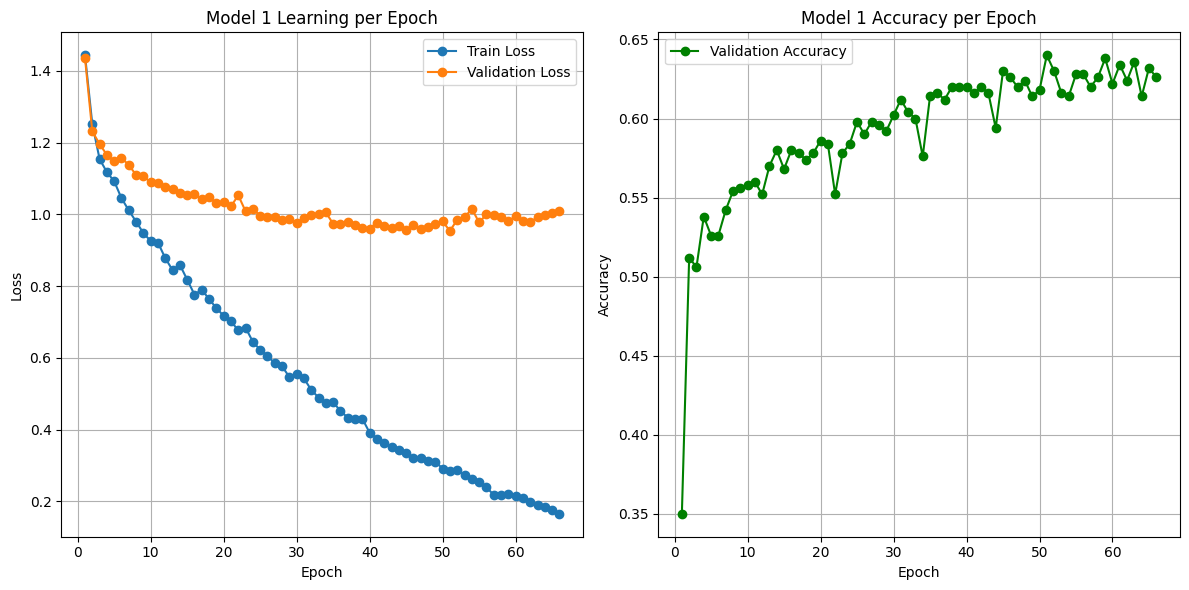

Model1 is saved to: CAS771/Task1_data/Model1/model1_weights.pth
Class mapping: {54: 0, 62: 1, 70: 2, 82: 3, 92: 4}
Epoch 1, Train Loss: 1.4023, Validation Loss: 1.3355, Validation Accuracy: 0.4820
Epoch 2, Train Loss: 1.1995, Validation Loss: 1.1452, Validation Accuracy: 0.5100
Epoch 3, Train Loss: 1.1315, Validation Loss: 1.0986, Validation Accuracy: 0.5540
Epoch 4, Train Loss: 1.0571, Validation Loss: 1.0652, Validation Accuracy: 0.5760
Epoch 5, Train Loss: 1.0231, Validation Loss: 1.0346, Validation Accuracy: 0.5780
Epoch 6, Train Loss: 1.0033, Validation Loss: 1.0063, Validation Accuracy: 0.5860
Epoch 7, Train Loss: 0.9685, Validation Loss: 0.9837, Validation Accuracy: 0.5960
Epoch 8, Train Loss: 0.9248, Validation Loss: 0.9695, Validation Accuracy: 0.6100
Epoch 9, Train Loss: 0.9023, Validation Loss: 0.9664, Validation Accuracy: 0.6120
Epoch 10, Train Loss: 0.8884, Validation Loss: 0.9678, Validation Accuracy: 0.5800
Epoch 11, Train Loss: 0.8630, Validation Loss: 0.9346, Validatio

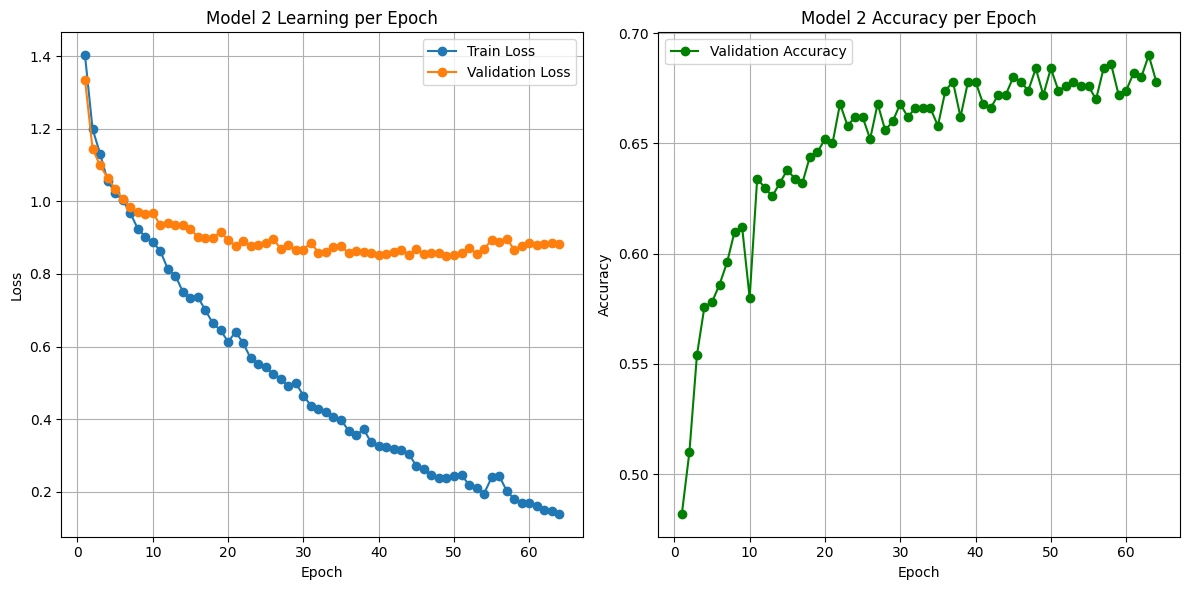

Model2 is saved to: CAS771/Task1_data/Model2/model2_weights.pth
Class mapping: {0: 0, 51: 1, 53: 2, 57: 3, 83: 4}
Epoch 1, Train Loss: 1.9662, Validation Loss: 1.6377, Validation Accuracy: 0.2400
Epoch 2, Train Loss: 1.8774, Validation Loss: 1.6005, Validation Accuracy: 0.3000
Epoch 3, Train Loss: 1.8441, Validation Loss: 1.5805, Validation Accuracy: 0.3220
Epoch 4, Train Loss: 1.7971, Validation Loss: 1.5393, Validation Accuracy: 0.3140
Epoch 5, Train Loss: 1.7783, Validation Loss: 1.5386, Validation Accuracy: 0.3500
Epoch 6, Train Loss: 1.7721, Validation Loss: 1.5330, Validation Accuracy: 0.3340
Epoch 7, Train Loss: 1.7340, Validation Loss: 1.5754, Validation Accuracy: 0.2980
Epoch 8, Train Loss: 1.7196, Validation Loss: 1.5161, Validation Accuracy: 0.3540
Epoch 9, Train Loss: 1.7358, Validation Loss: 1.5331, Validation Accuracy: 0.3240
Epoch 10, Train Loss: 1.7010, Validation Loss: 1.5081, Validation Accuracy: 0.3500
Epoch 11, Train Loss: 1.6578, Validation Loss: 1.4946, Validation

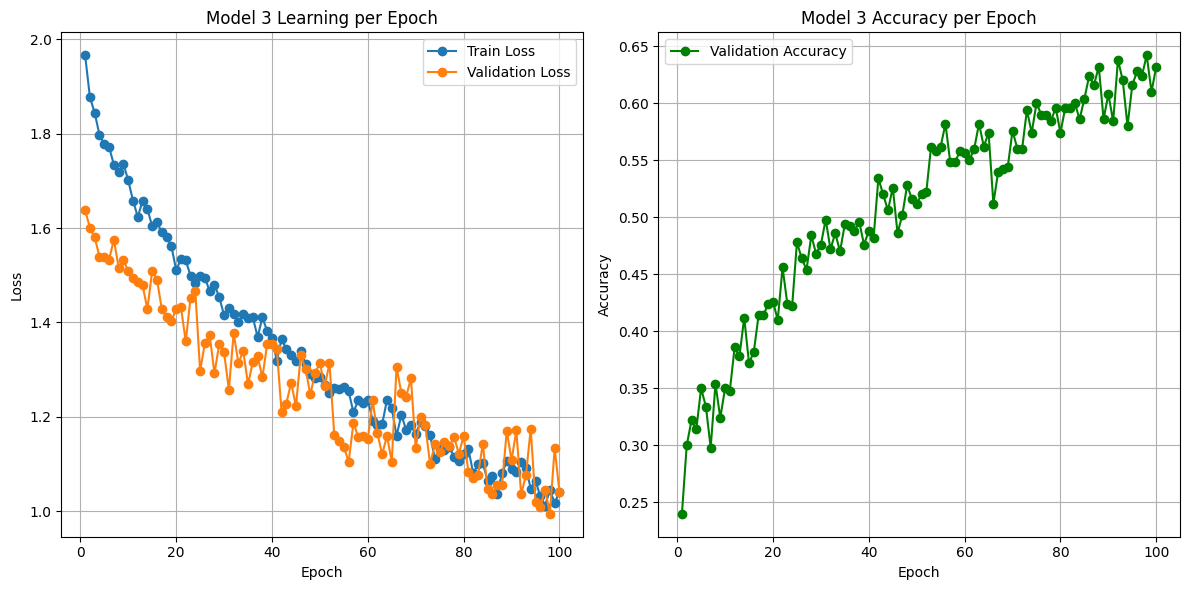

Model3 is saved to: CAS771/Task1_data/Model3/model3_weights.pth


In [236]:
models, optimizers, criterions = get_models(gModel_names, gOptimizer_names, gCriterion_names)

for m in range(gnDataset):
    model = models[m]
    optimizer = optimizers[m]
    criterion = criterions[m]
    train_dataloader, test_dataloader = load_data(train_data_paths[m], test_data_paths[m], m)

    progress = CAS771Plot(model, criterion, device, train_dataloader, test_dataloader, m)
    es = CAS771EarlyStopping()

    for epoch in range(gnEpochs):
        model.train()
        progress.init_running_loss()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())
        
        if es.isStop(progress.append(epoch)):
            break
    progress.plot()
    save_model(model, m)

    del model
torch.cuda.empty_cache()

